In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import sys
if "/content/drive/My Drive/Machine Learning/lib/" not in sys.path:
    sys.path.append("/content/drive/My Drive/Machine Learning/lib/") 

In [0]:
from envs.blackjack import BlackjackEnv
import plotting

import gym
import numpy as np
from collections import defaultdict

import matplotlib.pyplot as plt
%matplotlib inline

## Evaluate the Policy

- Using Monte Carlo prediction algorithm.(使用MC方法)
- Calculates the value function for a given policy using sampling. (对给定的policy进行评价, 也就是计算出value function/)
    

### 初始化环境

In [0]:
environment = BlackjackEnv()

### 定义一个policy

在这里我们定义一个policy为了方便对这个环境的了解. 

这个policy就是当我们手上牌的总和>18就不要牌, 否则就要牌. 

In [0]:
def strategy(observation):
    score, dealer_score, usable_ace = observation
    if score >= 20:
        return 0
    else:
        return 1

### 使用TD算法评价上面的Policy

这里我们会使用Eligibility traces来进行更新. 

其中Eligibility traces按照下面的进行更新, 每一个state都要进行记录.

$$
E_{t}(s) = 
\left\{
\begin{aligned}
    & 0 \quad & t=0 \\
    & \gamma \lambda E_{t-1}(s) \quad & S_{t} \neq s \\
    & \gamma \lambda E_{t-1}(s) + 1 \quad & S_{t}=s \\
\end{aligned}
\right.
$$

最后总的更新的式子.

$$
V(S_{t}) \leftarrow V(S_{t}) + \alpha E_{t}(s) (R_{t+1} + \gamma V(S_{s+1}) - V(S_{t}))
$$

### 完整的函数

In [0]:
def td_prediction(policy, env, num_episodes, alpha=0.1, lambda_return=0.5, discount_factor=1.0):
    """使用td的方法, 给每一个state一个eligibility traces, 对给定的policy进行评价.
    """
    # The final value function
    V = defaultdict(float)
    eligibility_traces = defaultdict(float)
    
    for i_episode in range(1, num_episodes + 1):
        # Print out which episode we're on, useful for debugging.
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        # Generate an episode.
        state = env._reset()
        for t in range(100):
            # 更新每一个state的eligibility traces
            for _state in eligibility_traces:
                eligibility_traces[_state] = eligibility_traces[_state]*discount_factor*lambda_return
            
            if state in eligibility_traces:
                eligibility_traces[state] = eligibility_traces[state] + 1
            else:
                eligibility_traces[state] = 1

            action = policy(state)
            next_state, reward, done, _ = env._step(action)

            if next_state[0] <= 21:
                delta = reward + discount_factor*V[next_state] - V[state]
            else:
                delta = reward + discount_factor*0 - V[state]

            V[state] = V[state] + alpha*delta*eligibility_traces[state]

            if done:
                break
            state = next_state

    return V

### 评价上面的policy且进行可视化

Episode 1000000/1000000.

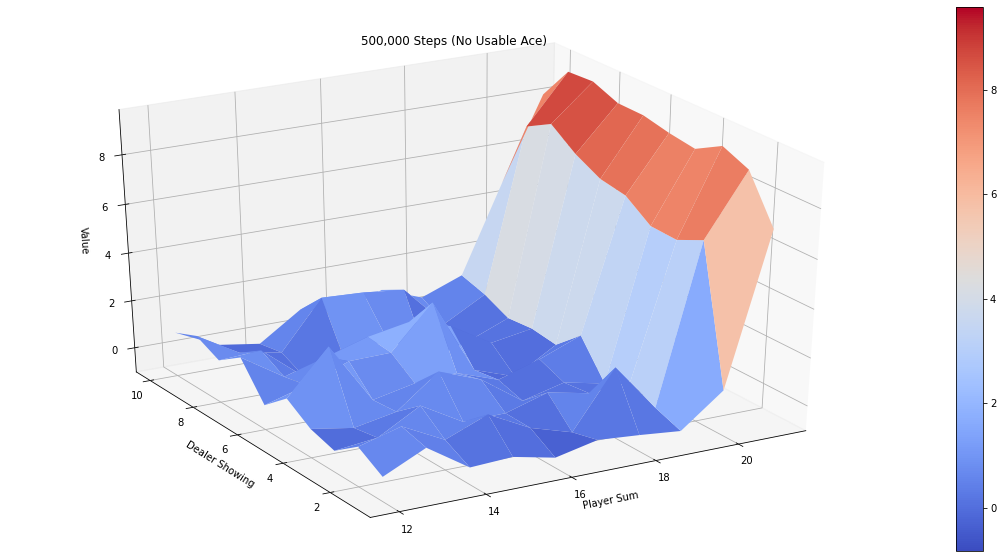

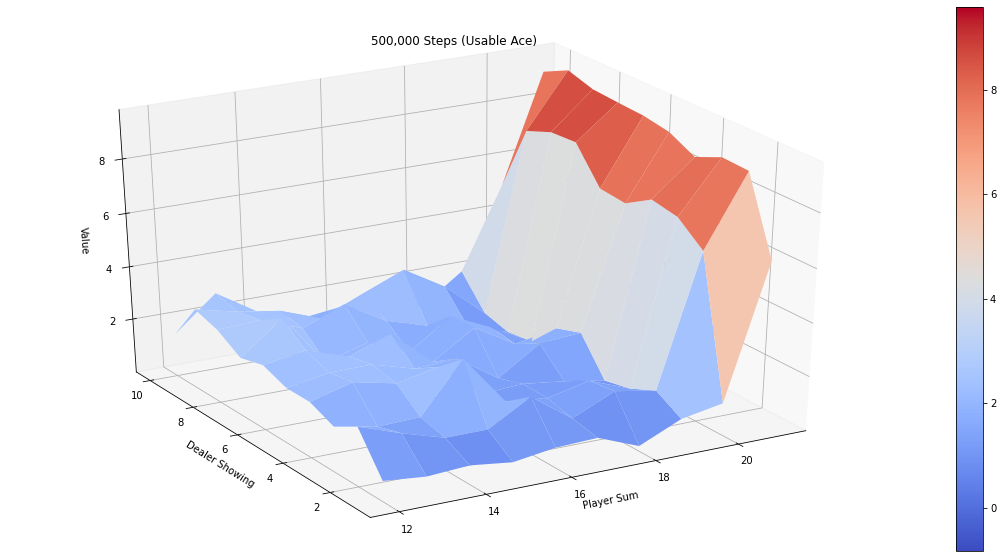

In [12]:
V_500k = td_prediction(strategy, environment, discount_factor=0.9, num_episodes=1000000)
plotting.plot_value_function(V_500k, title="500,000 Steps")